In [6]:
import aiida

# must execute it in the first place
aiida.load_profile()

In [7]:
from aiida.manage.configuration import get_profile

from aiida.common.datastructures import CalcInfo, CodeInfo
from aiida.common.folders import Folder

from aiida.engine import CalcJob, WorkChain
from aiida.engine import calcfunction, workfunction, submit, run

from aiida.plugins import DataFactory, WorkflowFactory

from aiida.parsers.parser import Parser
from aiida.orm import Code
from aiida.orm import load_code,load_node
from aiida.orm import Str, Dict, Float, Int
from aiida.orm import QueryBuilder

import aiida

from alamode_aiida.data_loader import load_anphon_kl, load_anphon_kl_spec

from ase.io.espresso import write_espresso_in
from ase.build import make_supercell
from ase import Atom, Atoms
import ase

from itertools import combinations_with_replacement
import numpy as np
import os
import subprocess
import shutil
import re
from time import sleep
import spglib

In [8]:
# load types
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')

In [9]:
g_graph = False

In [10]:
import json
import os
class NodeBank:
    _KEY= "pk"
    def __init__(self, parent_dir):
        self.filename = ".node.json"
        self.parent_dir = parent_dir
        self.filepath = os.path.join(self.parent_dir, self.filename)
        
    def load_json(self):
        filepath = self.filepath
        self.dic = {}
        if os.path.isfile(filepath):
            with open(filepath) as f:
                self.dic = json.load(f)
                
    def dump_json(self):
        filepath = self.filepath
        with open(filepath,"w") as f:
            json.dump(self.dic, f)
                
    def load(self, label, force=False):
        if force:
            return None
        
        self.load_json()
        if label in self.dic:
            if self._KEY == "pk":
                pk = self.dic[label]
                print("load", label, pk)
                return load_node(pk)
            else:
                uuid = self.dic[label]
                print("load", label, uuid)
                return load_node(uuid)
        else:
            return None
        
    def dump(self, label, node):
        if False:
            self.load_json()
            if label in self.dic:
                print("already stored. do nothing.")
                return 
        
        node.store()
        self.load_json()
        if self._KEY== "pk":
            self.dic[label] = node.pk
            print("save",label, node.pk)
            self.dump_json()
        else:
            self.dic[label] = node.uuid
            print("save",label, node.uuid)
            self.dump_json()

In [11]:
from os.path import expanduser
home = expanduser("~")

CWD = "run25"
nodebank = NodeBank(os.path.join(home,f"Documents/aiida-test/alamode-aiida/example/{CWD}"))
g_force = False
key = "root_wd"
g_root_wd = nodebank.load(key, g_force)
if g_root_wd is  None:
    g_root_wd = Str(os.path.join(os.getcwd(),CWD))
    os.makedirs(g_root_wd.value, exist_ok=True)
    nodebank.dump(key, g_root_wd)

save root_wd 23632


In [12]:
g_root_wd

<Str: uuid: daf0a92d-0edb-4564-b771-abcaf956021a (pk: 23632) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25>

In [13]:
g_norder = nodebank.load("norder", g_force)
if g_norder is None:
    g_norder = Int(1)
    nodebank.dump("norder", g_norder)
    

save norder 23633


In [14]:
def _wait_for_node_finished(node, sec=2):
    while True:
        if node.is_terminated:
            break
        print(f"wait another {sec} sec.")
        sleep(sec)
    print(node.is_finished, node.is_finished_ok)

In [15]:
@calcfunction
def make_atoms_supercell( filename: Str, 
                         diag: ArrayData,
                   ) -> StructureData:
    
    CifData = DataFactory('cif')
    cif = CifData(file=filename.value)
    print(cif.ase)
    # supercell
    _diag = diag.get_array('diag')
    P = np.diag(_diag) # define supercell.
    super_structure = make_supercell(cif.ase, P=P) # ase function
    super_structure = StructureData(ase=super_structure)
    
    return super_structure

@calcfunction
def make_atoms_primcell( filename : Str,
                   ) ->StructureData:
    
    CifData = DataFactory('cif')
    cif = CifData(file=filename.value)
    atoms = cif.ase
    # primitive cell
    cell, scaled_positions, numbers = spglib.find_primitive(
                atoms)
    prim_structure = Atoms(cell=cell, scaled_positions=scaled_positions,
                      numbers=numbers)    
    prim_structure = StructureData(ase=prim_structure)
    return prim_structure

@calcfunction
def structure_to_SinglefileData(structure: StructureData, 
                                cwd: Str,
                                filename: Str) -> SinglefileData:
    prim_structure = structure.get_ase()
    target_path = os.path.join(cwd.value, filename.value)
    ase.io.write(target_path, prim_structure, format="cif")
    prim_file = SinglefileData(target_path)
    return prim_file

class PutStructure(WorkChain):
    _PRIM_FILENAME = "primcell.cif"
    _SUPER_FILENAME = "supercell.cif"
    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("cwd", valid_type=Str)
        spec.input("structure_filename", valid_type=Str)
        spec.input("diag", valid_type=ArrayData)
        spec.input("primcell_filename", valid_type=Str, default=lambda: Str(cls._PRIM_FILENAME) )
        spec.input("supercell_filename", valid_type=Str, default=lambda: Str(cls._SUPER_FILENAME) )
        spec.outline(cls.put_primcell ,
                     cls.put_supercell)
        spec.output("primstructure", valid_type=StructureData)
        spec.output("superstructure", valid_type=StructureData)
        spec.output("primstructure_file",valid_type=SinglefileData)
        spec.output("superstructure_file",valid_type=SinglefileData)
    def put_primcell(self):
        
        primstructure = make_atoms_primcell(filename=self.inputs.structure_filename)
        self.out('primstructure', primstructure)
        primstructure_file = structure_to_SinglefileData(primstructure,
                                                        cwd = self.inputs.cwd,
                                                        filename = self.inputs.primcell_filename)
        self.out("primstructure_file", primstructure_file)
    def put_supercell(self):
        superstructure = \
        make_atoms_supercell(filename=self.inputs.structure_filename, 
                             diag = self.inputs.diag)
        self.out('superstructure',superstructure)
        superstructure_file = structure_to_SinglefileData(superstructure, 
                                                cwd = self.inputs.cwd,
                                                         filename = self.inputs.supercell_filename)
                                                   
        self.out("superstructure_file", superstructure_file)
    
        
g_ciffilename=Str(os.path.abspath('Si_Fd-3m.cif'))
g_ciffilename.store()
print(g_ciffilename)
g_diag = ArrayData()
g_diag.set_array('diag',np.array([2,2,1]))
inputs = {"cwd": g_root_wd, "diag": g_diag, "structure_filename": g_ciffilename}
g_putstructure = run(PutStructure, **inputs)

uuid: b55f3689-179f-473f-8229-1d7392a90be3 (pk: 23634) value: /home/max/Documents/aiida-test/alamode-aiida/example/Si_Fd-3m.cif
Atoms(symbols='Si8', pbc=True, cell=[5.431, 5.431, 5.431], tags=...)


In [16]:
g_putstructure

{'primstructure': <StructureData: uuid: e263c3b6-0a67-46cd-9f0a-2ee647924c52 (pk: 23640)>,
 'primstructure_file': <SinglefileData: uuid: bce9b683-6b6d-4d1d-87bc-02aebef43729 (pk: 23642)>,
 'superstructure': <StructureData: uuid: e7050dcd-de7e-45c8-a5ce-2938f5f7153e (pk: 23644)>,
 'superstructure_file': <SinglefileData: uuid: fe7ab2e9-6dae-4f7d-beb1-0559ab245877 (pk: 23646)>}

In [17]:
g_superstructure = g_putstructure["superstructure"]
g_primstructure = g_putstructure["primstructure"]

In [18]:
g_primstructure.get_ase()

Atoms(symbols='Si2', pbc=False, cell=[[0.0, 2.7155, 2.7155], [2.7155, 0.0, 2.7155], [2.7155, 2.7155, 0.0]], masses=...)

In [19]:
if g_graph:
    pk =g_ciffilename.pk 
    print(pk)
    !verdi node graph generate $pk

In [20]:
g_aiida_structure = nodebank.load("superstructure", g_force)
if g_aiida_structure is None:
    g_aiida_structure = g_superstructure
    g_aiida_structure.get_ase()
    nodebank.dump("structure", g_aiida_structure)

save structure 23644


In [21]:
g_aiida_structure

<StructureData: uuid: e7050dcd-de7e-45c8-a5ce-2938f5f7153e (pk: 23644)>

In [22]:
g_diag.get_array("diag")

array([2, 2, 1])

In [154]:
from alamode_aiida.alm_input import AlmPrefixMaker, AlmPathMaker

almp = AlmPathMaker(
                    name=g_primstructure.get_formula(),
                    kmesh=g_diag.get_array("diag"),
                   norder = g_norder)

g_cwd = Str(os.path.join(g_root_wd.value, almp.prefix))
os.makedirs(g_cwd.value, exist_ok=True)
print(g_cwd)

almp = AlmPrefixMaker(name=g_primstructure.get_formula(),
                      kmesh=g_diag.get_array("diag"),
                     norder=g_norder)

key = "prefix"
g_prefix = Str(almp.prefix)

print(g_prefix)


uuid: 8d776714-d83b-467f-a8b1-5c3950aabd99 (unstored) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/Si2_k2x2x1_cubic
uuid: bbb6fb5c-48ea-451a-8869-b7525beed63b (unstored) value: Si2_k2x2x1_cubic


In [24]:
key = "format"
g_format =  nodebank.load(key,g_force)
if g_format is None:
    g_format = Str("QE")
    nodebank.dump(key, g_format)

save format 23647


In [25]:
g_norder = nodebank.load("norder",g_force)
if g_norder is None:
    g_norder = Int(1)
    nodebank.dump("norder", g_norder)

load norder 23633


In [26]:
g_norder

<Int: uuid: 3e38cc39-74fc-4c5f-964c-044c13a6d669 (pk: 23633) value: 1>

## make QE input

In [27]:
from aiida.orm.nodes.data.upf import get_pseudos_from_structure

def _make_upf_locally( structure: StructureData, pseudos: str, cwd: str=None) -> dict:
    upflist = get_pseudos_from_structure(structure, pseudos)
    upfdic = {}
    for upfkey, upfvalue in upflist.items():
        #print(upfvalue.get_content())
        upf_filename = upfvalue.list_object_names()[0]
        upfdic[upfkey] = upf_filename
        if cwd is not None:
            target_path = os.path.join(cwd, upf_filename)
            with open(target_path,"w") as f:
                f.write(upfvalue.get_content())
            print(target_path,"is made.")
    return upfdic

In [28]:
def make_qe_input(superstructure: StructureData, pseudos: (str,Str), QEinput = "qe.in"):
    params = {
            'calculation': 'scf',
             'tprnfor': True, 
             'tstress': True,
            'pseudo_dir': ".", 
            'ecutwfc': 3.,
            'ecutrho': 10.,
            'conv_thr': 5.e-6,
            'electron_maxstep': 100,
    }

    if isinstance(pseudos,Str):
        pseudos = pseudos.value
    pseudo = _make_upf_locally(superstructure, pseudos)
    kspacing  = 0.05
    koffset  = (1,1,1)
    with open(QEinput,"w") as f:
        write_espresso_in(f, superstructure.get_ase(), pseudopotentials =pseudo, 
                          kspacing= kspacing, koffset=koffset, 
                      **params)
    return True

In [29]:
g_QEinput = nodebank.load("qeinput",g_force)
g_pseudos = Str('SSSP_1.1_efficiency')
# if g_QEinput is None:
if True:   
    g_QEinput_filename = os.path.join(g_root_wd.value,"qe.in")
    make_qe_input(g_superstructure, g_pseudos, g_QEinput_filename)
    g_QEinput = SinglefileData(g_QEinput_filename)
    nodebank.dump("qeinput",g_QEinput)

save qeinput 23648


In [30]:
g_norder

<Int: uuid: 3e38cc39-74fc-4c5f-964c-044c13a6d669 (pk: 23633) value: 1>

## alm suggest

In [31]:
codename = "alm@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_aiida_structure
builder.prefix = g_prefix
builder.norder = g_norder
builder.mode = Str("suggest")
builder.cwd = g_cwd

builder.metadata = {
        'options': {
           'resources': {'tot_num_mpiprocs': 1, 'num_machines': 1}
        } }

g_alm_suggest_future = nodebank.load("alm_suggest",g_force)
if g_alm_suggest_future is None: 
#if True:
    g_alm_suggest_future = submit(builder) # temporary run(), use submit()
    print(g_alm_suggest_future)
    _wait_for_node_finished(g_alm_suggest_future)
    if g_alm_suggest_future.is_finished_ok:
        nodebank.dump("alm_suggest",g_alm_suggest_future)


uuid: bfbc3fce-d0e3-4e4b-bcb0-0f951be27904 (pk: 23656) (aiida.calculations:alamode.alm)
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True
save alm_suggest 23656


In [32]:
g_alm_suggest_future

<CalcJobNode: uuid: bfbc3fce-d0e3-4e4b-bcb0-0f951be27904 (pk: 23656) (aiida.calculations:alamode.alm)>

In [33]:
if g_graph:
    !verdi node graph generate $g_alm_suggest_future.pk

In [34]:
g_alm_suggest_future.outputs.pattern_folder.list_object_names()

['Si2_k2x2x1_harmonic.pattern_HARMONIC']

# 重要: 

1. 複数のSinglefileDataはnodeとすることができない。次に使うSinglefileDataは、次のworkchain/calcjobで取得しする。

2. もしくはまとめてFolderDataとする。

## displace.py

In [35]:
g_mag = nodebank.load("mag", g_force)
if g_mag is None:
    g_mag = Float(0.01)
    nodebank.dump("mag", g_mag)

save mag 23661


In [36]:
from fnmatch import fnmatch

In [37]:
@calcfunction
def _pack_harmonic_pattern_files(**kwargs):
    print(kwargs)
    result = []
    for _, folder in kwargs.items():
        for filename in folder.list_object_names():
            if fnmatch(filename,"*.pattern_HARMONIC"):
                result.append(filename)
    return Dict(dict={'pattern_files':result})
    
inputs = {
    "pattern1": g_alm_suggest_future.outputs.pattern_folder
}

g_pattern_files = nodebank.load("pattern_file",g_force)
if g_pattern_files is None:
    g_pattern_files = _pack_harmonic_pattern_files(**inputs)
    nodebank.dump("pattern_file",g_pattern_files)

{'pattern1': <FolderData: uuid: a7b15011-1209-4ad9-9b30-1cfa2a4bfab7 (pk: 23660)>}
save pattern_file 23663


In [38]:
g_pattern_files.attributes["pattern_files"]

['Si2_k2x2x1_harmonic.pattern_HARMONIC']

In [39]:
for filename in g_pattern_files.attributes['pattern_files']:
    print(filename)

Si2_k2x2x1_harmonic.pattern_HARMONIC


In [40]:
g_QEinput.attributes["filename"]

'qe.in'

In [41]:
g_disp_start_id = nodebank.load("start_id", g_force)
if g_disp_start_id is None:
    g_disp_start_id = Int(1)
    nodebank.dump("start_id", g_disp_start_id)

save start_id 23664


In [42]:
codename = "alamode.displace@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.format = g_format
builder.cwd = g_cwd
builder.structure_org = g_QEinput
builder.mag = g_mag
builder.pattern_files = g_pattern_files

g_displacefuture = nodebank.load("displace", g_force)
if g_displacefuture is None:
    g_displacefuture = submit(builder)
    print(g_displacefuture)
    _wait_for_node_finished(g_displacefuture)
    if g_displacefuture.is_finished_ok:
        nodebank.dump("displace", g_displacefuture)

uuid: 212e1692-2c4a-4a66-8afb-03b429e7d4e9 (pk: 23667) (aiida.calculations:alamode.displace)
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True
save displace 23667


In [43]:
g_displacefuture

<CalcJobNode: uuid: 212e1692-2c4a-4a66-8afb-03b429e7d4e9 (pk: 23667) (aiida.calculations:alamode.displace)>

In [44]:
if g_graph:
    !verdi node graph generate $g_displacefuture.pk

In [45]:
g_displacefuture.outputs.result

<Int: uuid: 461d8df0-4007-47c5-8f26-a1ebe6b1b5e8 (pk: 23670) value: 2>

In [46]:
g_displacefuture.outputs.retrieved.list_object_names()

['_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'disp1.pw.in',
 'disp2.pw.in',
 'displace.out']

In [47]:
g_displacefuture.outputs.dispfile_folder.list_object_names()

['disp1.pw.in', 'disp2.pw.in']

## pwx parallel submit

In [48]:
g_displacefuture.outputs.dispfile_folder.list_object_names()

['disp1.pw.in', 'disp2.pw.in']

In [49]:
if g_graph:
    !verdi node graph generate $g_pwx_files.pk

In [50]:
g_cwd

<Str: uuid: 41cdd86e-6ad2-402c-a80a-d5cc30796ecf (pk: 23651) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/Si2_k2x2x1_harmonic>

In [51]:
# single file test
if False:
    codename = "alamode.pwx@mygarden1"
    code = Code.get_from_string(codename)

    builder = code.get_builder()
    builder.cwd = g_cwd
    builder.pwx_input_filename = Str('disp1.pw.in')
    builder.pseudos = g_pseudos
    #builder.pwx_output_filename = Str('disp1.pw.out')
    #builder.xml_filename = Str('disp1.xml')

    if True:
        g_displacefuture = run(builder)
        _wait_for_node_finished(g_displacefuture, 5)
        print(g_displacefuture)
    else:
        g_displacefuture = load_node(9949)

In [52]:
g_displacefuture.outputs.dispfile_folder.list_object_names()
g_codelist = List(list=["alamode.pwx@mygarden1",
                  "alamode.pwx@mygarden2"])
g_displacefuture.outputs.dispfile_folder.list_object_names()


['disp1.pw.in', 'disp2.pw.in']

In [53]:
g_alldisp_pwx = WorkflowFactory("alamode.dispall_pwx")

# g_code_str = Str("alamode.pwx@mygarden1")

g_pwx_all_future = nodebank.load("dispall", g_force)
# if g_pwx_all_future is None:
if True:
    g_pwx_all_future = submit(g_alldisp_pwx, 
                pwx_input_folder=g_displacefuture.outputs.dispfile_folder, 
                pseudos = g_pseudos, 
                code_string = g_codelist, 
                cwd=g_cwd)
    print(g_pwx_all_future)
    _wait_for_node_finished(g_pwx_all_future, 10)
    if g_pwx_all_future.is_finished_ok:
        nodebank.dump("dispall", g_pwx_all_future)

uuid: ddf7eb5f-63b1-4902-94dc-1715acfa8c96 (pk: 23675) (aiida.workflows:alamode.dispall_pwx)
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
wait another 10 sec.
True True
save dispall 23675


In [54]:
g_pwx_all_future.outputs.pwx_output

<List: uuid: 70750188-3f48-40a2-a830-ee5b23ef383d (pk: 23699) value: ['disp1.pw.out', 'disp2.pw.out']>

In [55]:
#if g_graph:
if True:
    !verdi node graph generate $g_pwx_all_future.pk

Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 23675.dot.pdf


In [56]:
g_pwx_all_future.outputs.pwx_output.attributes

{'list': ['disp1.pw.out', 'disp2.pw.out']}

## extract

In [57]:
g_pwx_all_future

<WorkChainNode: uuid: ddf7eb5f-63b1-4902-94dc-1715acfa8c96 (pk: 23675) (aiida.workflows:alamode.dispall_pwx)>

In [58]:
g_pwx_all_future.outputs.pwx_output.get_list()

['disp1.pw.out', 'disp2.pw.out']

In [59]:
extractworkchain = WorkflowFactory("alamode.extract")

inputs= {'QE': g_QEinput, 
         'target_file': g_pwx_all_future.outputs.pwx_output, 
         'cwd': g_cwd,
         "norder": g_norder
        # 'output_filename' : g_DFSET_filename
        }
print(inputs)

g_alamodeextract_future = nodebank.load("extract", g_force)
if g_alamodeextract_future is None:
    g_alamodeextract_future = submit(extractworkchain, **inputs)
    print(g_alamodeextract_future)
    _wait_for_node_finished(g_alamodeextract_future)
    if g_alamodeextract_future.is_finished_ok:
        nodebank.dump("extract", g_alamodeextract_future)


{'QE': <SinglefileData: uuid: ef7872ba-27cd-4e57-9e97-366f0c079b6c (pk: 23648)>, 'target_file': <List: uuid: 70750188-3f48-40a2-a830-ee5b23ef383d (pk: 23699) value: ['disp1.pw.out', 'disp2.pw.out']>, 'cwd': <Str: uuid: 41cdd86e-6ad2-402c-a80a-d5cc30796ecf (pk: 23651) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/Si2_k2x2x1_harmonic>, 'norder': <Int: uuid: 3e38cc39-74fc-4c5f-964c-044c13a6d669 (pk: 23633) value: 1>}
uuid: a22e911b-8891-4c5d-ab63-0e591de66ff9 (pk: 23702) (aiida.workflows:alamode.extract)
wait another 2 sec.
True True
save extract 23702


In [60]:
g_alamodeextract_future

<WorkChainNode: uuid: a22e911b-8891-4c5d-ab63-0e591de66ff9 (pk: 23702) (aiida.workflows:alamode.extract)>

In [61]:
g_alamodeextract_future.outputs.dfset_file

<SinglefileData: uuid: 9e1f9f0f-31f9-43c4-ad44-4c0bd5cb2e73 (pk: 23704)>

In [62]:
if g_graph:
    !verdi node graph generate $g_alamodeextract_future.pk

In [63]:
g_DFSET_file = g_alamodeextract_future.outputs.dfset_file
g_DFSET_file.attributes["filename"]

'DFSET_harmonic'

## alm opt

In [64]:
g_alamodeextract_future

<WorkChainNode: uuid: a22e911b-8891-4c5d-ab63-0e591de66ff9 (pk: 23702) (aiida.workflows:alamode.extract)>

In [65]:
#g_aiida_structure = load_node(7970)
#g_prefix = load_node(7973)
#g_cwd  = load_node(7971)

g_DFSET_file = g_alamodeextract_future.outputs.dfset_file

In [153]:
from alamode_aiida.alm_input import alm_norder_name

almp = AlmPrefixMaker(name=g_primstructure.get_formula(),
                      kmesh=g_diag.get_array("diag"),
                      norder = g_norder.value)
g_prefix = Str(almp.prefix)
g_prefix

<Str: uuid: c98b88bd-bc77-4742-8ed3-dd1d75d5e640 (unstored) value: Si2_k2x2x1_cubic>

In [67]:
codename = "alm@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_aiida_structure
builder.prefix = g_prefix
builder.cwd = g_cwd
builder.mode = Str("opt")
builder.norder = g_norder
builder.dfset_file = g_DFSET_file

key = "almopt"
g_almoptfuture = nodebank.load(key,g_force)
if g_almoptfuture is None:
#if True:
    g_almoptfuture = submit(builder)
    print(g_almoptfuture)
    _wait_for_node_finished(g_almoptfuture, 5)
    if g_almoptfuture.is_finished_ok:
        nodebank.dump(key, g_almoptfuture)


uuid: dc528baf-8bcf-4a5a-8641-8b0e94a1d70c (pk: 23710) (aiida.calculations:alamode.alm)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save almopt 23710


In [68]:
g_almoptfuture.outputs.input_ANPHON_file.attributes

{'filename': 'Si2_k2x2x1_harmonic.xml'}

In [69]:
if g_graph:
    !verdi node graph generate $g_almoptfuture.pk

# anphon phonon

In [70]:
g_prefix

<Str: uuid: 95dacdf4-3666-4673-96ee-e85bdb95b9ac (pk: 23705) value: Si2_k2x2x1_harmonic>

In [71]:
g_cwd = Str(os.path.join(g_root_wd.value, "property"))
os.makedirs(g_cwd.value, exist_ok=True)

In [72]:
codename = "anphon@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_prefix
builder.cwd = g_cwd
# builder.norder = g_norder
builder.fcsxml = g_almoptfuture.outputs.input_ANPHON_file
builder.mode = Str("phonons")
builder.phonons_mode = Str("band")
#builder.kparam = Dict(dict={}) # should merge to the input port, param.

g_phbandfuture = nodebank.load("phband", g_force)

if g_phbandfuture is None:
#if True:
    g_phbandfuture = submit(builder)
    print(g_phbandfuture)
    _wait_for_node_finished(g_phbandfuture, 5)
    nodebank.dump("phband", g_phbandfuture)

uuid: e84689f6-63bd-4066-b0d9-8f9979b50778 (pk: 23723) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save phband 23723


In [73]:
g_phbandfuture

<CalcJobNode: uuid: e84689f6-63bd-4066-b0d9-8f9979b50778 (pk: 23723) (aiida.calculations:alamode.anphon)>

In [74]:
from alamode_aiida.alm_input import make_alm_uniform_kmesh

In [155]:
g_qmesh_value = make_alm_uniform_kmesh(g_primstructure.get_ase(),kspacing=0.1)

amp = AlmPrefixMaker(name=g_primstructure.get_formula(), 
                     kmesh=g_diag.get_array("diag"), 
                     norder = g_norder.value, 
                     qmesh=g_qmesh_value )
g_prefix_dos = Str(amp.prefix)
g_prefix_dos

<Str: uuid: e77f9210-f295-42ee-8d2b-aee11f4fab34 (unstored) value: Si2_k2x2x1_cubic_q4x4x4>

In [76]:
g_qmesh = List(list=[10,10,10])

In [77]:
codename = "anphon@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_prefix_dos
builder.cwd = g_cwd
# builder.norder = g_norder
builder.fcsxml = g_almoptfuture.outputs.input_ANPHON_file
builder.mode = Str("phonons")
builder.phonons_mode = Str("dos")
builder.qmesh = g_qmesh

g_phdosfuture = nodebank.load("phdos",g_force)
if g_phdosfuture is None:
#if True:
    g_phdosfuture = submit(builder)
    print(g_phdosfuture)
    _wait_for_node_finished(g_phdosfuture, 5)
    if g_phdosfuture.is_finished_ok:
         nodebank.dump("phdos",g_phdosfuture)

uuid: a120b95e-3739-43e1-8781-c3566ecb57e4 (pk: 23735) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save phdos 23735


In [78]:
g_phdosfuture.outputs.phdos_file.list_object_names()

['Si2_k2x2x1_harmonic_q4x4x4.dos']

In [79]:
if False:
    @calcfunction
    def FolderData_to_filename(outputfiles: FolderData, prefix: Str, mode: Str):
        band_filename = f"{prefix.value}.{mode.value}"
        if band_filename in outputfiles.list_object_names():
            return Str(band_filename)
        else:
            raise ValueError(f"No band file={band_filename} is found in outputfiles List.")

## band plot

In [80]:
g_prefix

<Str: uuid: 95dacdf4-3666-4673-96ee-e85bdb95b9ac (pk: 23705) value: Si2_k2x2x1_harmonic>

In [81]:
g_phbandfuture.outputs.phband_file.list_object_names()

['Si2_k2x2x1_harmonic.bands']

In [82]:
phbandworkchain = WorkflowFactory('alamode.phband_img')
# g_img_filename = Str(f"{g_prefix.value}_phband.pdf")
g_band_filenames = g_phbandfuture.outputs.phband_file
inputs = {"cwd": g_cwd, "band_filenames": g_band_filenames, "prefix": g_prefix}
print(inputs)

{'cwd': <Str: uuid: 1c663691-7ffa-49c3-97e8-b250474f9277 (pk: 23716) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/property>, 'band_filenames': <SinglefileData: uuid: 11ad874d-1cc5-4f3f-8baf-0cfc1ed4ee7e (pk: 23726)>, 'prefix': <Str: uuid: 95dacdf4-3666-4673-96ee-e85bdb95b9ac (pk: 23705) value: Si2_k2x2x1_harmonic>}


In [83]:
isinstance(g_band_filenames,SinglefileData)

True

In [84]:
phbandimgworkchain = nodebank.load("phbandimg", g_force)
if phbandimgworkchain is None:
#if True:
    phbandimgworkchain = submit(phbandworkchain, **inputs)
    print(phbandimgworkchain)
    _wait_for_node_finished(phbandimgworkchain)
    if phbandimgworkchain.is_finished_ok:
         nodebank.dump("phbandimg",phbandimgworkchain)

uuid: 7a0e782e-8f17-48bd-84ba-f9fea429d4e4 (pk: 23743) (aiida.workflows:alamode.phband_img)
wait another 2 sec.
True True
save phbandimg 23743


In [85]:
phbandimgworkchain

<WorkChainNode: uuid: 7a0e782e-8f17-48bd-84ba-f9fea429d4e4 (pk: 23743) (aiida.workflows:alamode.phband_img)>

In [86]:
phbandimgworkchain.outputs.img_file

<SinglefileData: uuid: 3d2f21bd-a439-460c-90ee-0b791e49db2f (pk: 23745)>

## DOS plot

In [87]:
g_phdosfuture.outputs.phdos_file

<SinglefileData: uuid: ebcde9ef-f139-4209-8f00-c4ac9085d9f0 (pk: 23738)>

In [88]:
from alamode_aiida.alm_input import make_kspacing_kmeshlist, make_alm_uniform_kmesh
make_kspacing_kmeshlist(g_primstructure.get_ase())

,kspacing,na,nb,nc
0,0.100000,4,4,4
1,0.083378,4,4,4
2,0.069519,5,5,5
3,0.057964,6,6,6
4,0.048329,7,7,7
5,0.040296,8,8,8
6,0.033598,10,10,10
7,0.028014,12,12,12
8,0.023357,14,14,14
9,0.019475,17,17,17


In [89]:
g_prefix_dos

<Str: uuid: f3b804f9-39e5-4bdd-90d8-bcaa9c227295 (pk: 23728) value: Si2_k2x2x1_harmonic_q4x4x4>

In [90]:

phdosworkchain = WorkflowFactory('alamode.phdos_img')

inputs = {"cwd": g_cwd, "dos_filenames": g_phdosfuture.outputs.phdos_file,
          "prefix": g_prefix_dos}
print(inputs)

g_dosfuture = nodebank.load("phdosimg", g_force)
if g_dosfuture is None:
#if True:
    g_dosfuture = submit(phdosworkchain, **inputs)
    print(g_dosfuture)
    _wait_for_node_finished(g_dosfuture)
    if g_dosfuture.is_finished_ok:
        nodebank.dump("phdosimg",g_dosfuture)


{'cwd': <Str: uuid: 1c663691-7ffa-49c3-97e8-b250474f9277 (pk: 23716) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/property>, 'dos_filenames': <SinglefileData: uuid: ebcde9ef-f139-4209-8f00-c4ac9085d9f0 (pk: 23738)>, 'prefix': <Str: uuid: f3b804f9-39e5-4bdd-90d8-bcaa9c227295 (pk: 23728) value: Si2_k2x2x1_harmonic_q4x4x4>}
uuid: 46b8fbf0-e1b3-4e34-b72c-acb5364f91a4 (pk: 23748) (aiida.workflows:alamode.phdos_img)
wait another 2 sec.
True True
save phdosimg 23748


In [91]:
g_dosfuture.outputs.img_file.attributes

{'filename': 'Si2_k2x2x1_harmonic_q4x4x4_phdos.pdf'}

## thermo plot

In [92]:
g_prefix_dos

<Str: uuid: f3b804f9-39e5-4bdd-90d8-bcaa9c227295 (pk: 23728) value: Si2_k2x2x1_harmonic_q4x4x4>

In [93]:
FreeenergyImgWorkChain = WorkflowFactory("alamode.freeenergy_img")            
g_img_filename = Str("phdos_freeenergy.pdf")
g_inputs = {'cwd': g_cwd,'prefix': g_prefix_dos, 
            'thermo_file': g_phdosfuture.outputs.thermo_file}

freeenergyimgfuture = nodebank.load("freeenergyimg", g_force)
if freeenergyimgfuture is None:
#if True:   
    freeenergyimgfuture = submit(FreeenergyImgWorkChain, **g_inputs)
    print(freeenergyimgfuture)
    _wait_for_node_finished(freeenergyimgfuture)
    if freeenergyimgfuture.is_finished_ok:
        nodebank.dump("freeenergyimg",freeenergyimgfuture)


uuid: 9018e5c5-2041-422c-a0b1-cd2bcbe3b4c4 (pk: 23753) (aiida.workflows:alamode.freeenergy_img)
wait another 2 sec.
True True
save freeenergyimg 23753


In [94]:
freeenergyimgfuture.outputs.img_file.list_object_names()

['Si2_k2x2x1_harmonic_q4x4x4_phfreeenergy.pdf']

In [95]:
freeenergyimgfuture

<WorkChainNode: uuid: 9018e5c5-2041-422c-a0b1-cd2bcbe3b4c4 (pk: 23753) (aiida.workflows:alamode.freeenergy_img)>

# cubic term


## alm suggest

In [96]:
key = 'norder2_suggest'
g_norder = nodebank.load(key)
if g_norder is None:
    g_norder = Int(2)
    nodebank.dump(key, g_norder)

save norder2_suggest 23756


In [97]:
key = "cutoff2"
g_cutoff = nodebank.load(key)
if g_cutoff is None:
#if True:
    g_cutoff = Dict(dict={"Si-Si": {None, 7.3}})
    nodebank.dump(key, g_cutoff)

save cutoff2 23757


In [98]:
g_cutoff.attributes

{'Si-Si': [None, 7.3]}

In [152]:
almp = AlmPathMaker(name=g_primstructure.get_formula(),
                      kmesh=g_diag.get_array("diag"),
                   norder = g_norder)

g_cwd = Str(os.path.join(g_root_wd.value, almp.prefix))
os.makedirs(g_cwd.value, exist_ok=True)
print(g_cwd)

uuid: 77ccf5b7-c5d5-49a8-8f83-0dc704ea8bc9 (unstored) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/Si2_k2x2x1_cubic


In [100]:
codename = "alm@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_aiida_structure
#builder.prefix = g_prefix
builder.mode = Str("suggest")
builder.cwd = g_cwd
builder.norder = g_norder
builder.cutoff = g_cutoff

builder.metadata = {
        'options': {
           'resources': {'tot_num_mpiprocs': 1, 'num_machines': 1}
        } }

key = "alm_suggest_cubic"
g_alm_suggest_future = nodebank.load(key,g_force)
if g_alm_suggest_future is None: 
#if True:    
    g_alm_suggest_future = submit(builder) # temporary run(), use submit()
    print(g_alm_suggest_future)
    _wait_for_node_finished(g_alm_suggest_future, 5)
    if g_alm_suggest_future.is_finished_ok:
        nodebank.dump(key,g_alm_suggest_future)


uuid: 147e7768-4b3b-4c4e-9e02-96cca115368f (pk: 23764) (aiida.calculations:alamode.alm)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save alm_suggest_cubic 23764


In [101]:
g_alm_suggest_future.outputs.pattern_folder.list_object_names()

['alamode.pattern_ANHARM3', 'alamode.pattern_HARMONIC']

## displace

In [103]:
key = "mag_cubic"
g_mag = nodebank.load(key, g_force)
if g_mag is None:
    g_mag = Float(0.04)
    nodebank.dump(key, g_mag)

load mag_cubic 23769


In [104]:
@calcfunction
def _pack_cubic_pattern_files(**kwargs):
    print(kwargs)
    result = []
    for _, folder in kwargs.items():
        for filename in folder.list_object_names():
            if fnmatch(filename,"*.pattern_ANHARM3"):
                result.append(filename)
    return Dict(dict={'pattern_files':result})

inputs = {
    "pattern1": g_alm_suggest_future.outputs.pattern_folder
}

key = "cubic_pattern_file"
g_pattern_files = nodebank.load(key,g_force)
#if g_pattern_files is None:
if True:
    g_pattern_files = _pack_cubic_pattern_files(**inputs)
    nodebank.dump(key,g_pattern_files)

{'pattern1': <FolderData: uuid: 733f3af8-3d94-4b70-8d49-e76bfbabee70 (pk: 23768)>}
save cubic_pattern_file 23771


In [105]:
g_norder

<Int: uuid: 91697a90-f4d4-4821-822d-022de1b80f6b (pk: 23756) value: 2>

In [106]:
codename = "alamode.displace@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.format = g_format
builder.cwd = g_cwd
builder.norder = g_norder
builder.structure_org = g_QEinput
# builder.start_id = g_disp_start_id
builder.mag = g_mag
builder.pattern_files = g_pattern_files

key = "displace_cubic"
g_displacefuture = nodebank.load(key, g_force)
if g_displacefuture is None:
#if True:
    g_displacefuture = submit(builder)
    print(g_displacefuture)
    _wait_for_node_finished(g_displacefuture)
    if g_displacefuture.is_finished_ok:
        nodebank.dump(key, g_displacefuture)

uuid: 5308559d-93b5-46b5-8484-b438d0d409a5 (pk: 23773) (aiida.calculations:alamode.displace)
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True
save displace_cubic 23773


In [107]:
g_displacefuture.outputs.dispfile_folder.list_object_names()

['disp01.pw.in',
 'disp02.pw.in',
 'disp03.pw.in',
 'disp04.pw.in',
 'disp05.pw.in',
 'disp06.pw.in',
 'disp07.pw.in',
 'disp08.pw.in',
 'disp09.pw.in',
 'disp10.pw.in',
 'disp11.pw.in',
 'disp12.pw.in',
 'disp13.pw.in',
 'disp14.pw.in',
 'disp15.pw.in',
 'disp16.pw.in',
 'disp17.pw.in',
 'disp18.pw.in',
 'disp19.pw.in',
 'disp20.pw.in',
 'disp21.pw.in',
 'disp22.pw.in',
 'disp23.pw.in',
 'disp24.pw.in',
 'disp25.pw.in',
 'disp26.pw.in',
 'disp27.pw.in',
 'disp28.pw.in',
 'disp29.pw.in',
 'disp30.pw.in',
 'disp31.pw.in',
 'disp32.pw.in',
 'disp33.pw.in',
 'disp34.pw.in',
 'disp35.pw.in']

In [108]:
g_cwd

<Str: uuid: 213409d3-d69d-4d9a-a23f-23668ac9c46c (pk: 23759) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/Si2_k2x2x1_cubic>

## pw all

In [109]:
if False: # don't run it. Too heavy.
    g_alldisp_pwx = WorkflowFactory("alamode.dispall_pwx")

    # g_code_str = Str("alamode.pwx@mygarden1")

    key = "dispall_cubic"
    g_pwx_all_future = nodebank.load(key, g_force)
    if g_pwx_all_future is None:
        g_pwx_all_future = run(g_alldisp_pwx, 
                    pwx_input_folder=g_displacefuture.outputs.dispfile_folder, 
                    code_string = g_codelist, 
                    cwd=g_cwd, norder=g_norder)
        print(g_pwx_all_future)
        _wait_for_node_finished(g_pwx_all_future, 10)
        if g_pwx_all_future.is_finished_ok:
            nodebank.dump(key, g_pwx_all_future)


## alm opt norder=2

restarting from tutorial/Si sample

*please copy DFSET_cubic from Si/reference*

In [113]:
g_cwd

<Str: uuid: 213409d3-d69d-4d9a-a23f-23668ac9c46c (pk: 23759) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/Si2_k2x2x1_cubic>

In [114]:
g_norder

<Int: uuid: 91697a90-f4d4-4821-822d-022de1b80f6b (pk: 23756) value: 2>

In [115]:
g_DFSET_file = SinglefileData(os.path.join(g_cwd.value,"DFSET_cubic"))
g_DFSET_file

<SinglefileData: uuid: b2907643-09af-44a8-8ad6-359508284a51 (unstored)>

In [156]:
amp = AlmPrefixMaker(name=g_primstructure.get_formula(), 
                     kmesh=g_diag.get_array("diag"), 
                     norder=g_norder.value )
g_prefix =Str(amp.prefix)


In [117]:
codename = "alm@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_aiida_structure
builder.prefix = g_prefix
builder.cwd = g_cwd
builder.mode = Str("opt")
builder.norder = g_norder
builder.dfset_file = g_DFSET_file
builder.fc2xml_file =  g_almoptfuture.outputs.input_ANPHON_file

key = "almopt_cubic"
g_almopt2future = nodebank.load(key,g_force)

if g_almopt2future is None:
#if True:
    g_almopt2future = submit(builder)
    print(g_almopt2future)
    _wait_for_node_finished(g_almopt2future, 5)
    if g_almopt2future.is_finished_ok:
        nodebank.dump(key, g_almopt2future)


uuid: d50c8718-e85d-4765-9532-2f113e61eedd (pk: 23783) (aiida.calculations:alamode.alm)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save almopt_cubic 23783


In [118]:
if True:
    ! verdi node graph generate $g_almopt2future.pk

Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 23783.dot.pdf


In [119]:
g_almopt2future.outputs.result.attributes

{'constraint': {'constraint_T-inv': 2,
  'num_free_HARMINC_FCs': 0,
  'constraint_R-inv_self': 0,
  'constraint_R-inv_cross': 0,
  'inqeuv_constraint_self': 2,
  'inqeuv_constraint_cross': 0},
 'outputfiles': {'input_ANPHON': 'Si2_k2x2x1_cubic.xml',
  'force_constants': 'Si2_k2x2x1_cubic.fcs'},
 'optimization': {'LMODEL': 'least-squares',
  'num_param': 621,
  'num_free_param': 548}}

In [120]:
g_almopt2future.outputs.force_constants_file

<SinglefileData: uuid: bbb32eed-677d-4972-a44c-5cb2e3a4930e (pk: 23787)>

In [121]:
g_almopt2future.outputs.input_ANPHON_file

<SinglefileData: uuid: f36053e3-5e23-4926-bed6-3021a8aed677 (pk: 23786)>

# analysis

## thermal conductivity


In [122]:
g_qmesh = [5,5,5,]
almp = AlmPrefixMaker(name=g_primstructure.get_formula(),
                      kmesh=g_diag.get_array("diag"),
                      norder=g_norder.value,
                      qmesh = g_qmesh)
g_prefix = Str(almp.prefix)
g_prefix

<Str: uuid: 1e795ab7-38d5-437d-9ed4-20fd1e83503e (unstored) value: Si2_k2x2x1_cubic_q5x5x5>

In [123]:
g_almopt2future.outputs.input_ANPHON_file.list_object_names()

['Si2_k2x2x1_cubic.xml']

In [124]:
g_cwd = Str(os.path.join(g_root_wd.value, "property"))
g_cwd

<Str: uuid: eea9ba45-39e9-4df6-88e7-aedeb003863f (unstored) value: /home/max/Documents/aiida-test/alamode-aiida/example/run25/property>

In [125]:
codename = "anphon@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_prefix
builder.cwd = g_cwd
builder.norder = g_norder
builder.fcsxml = g_almopt2future.outputs.input_ANPHON_file
builder.mode = Str("RTA")
#builder.kparam = Dict(dict={"kspacing": 0.1})
builder.qmesh = List(list=g_qmesh)

key = "RTA"
g_RTAfuture = nodebank.load(key,g_force)
#if g_RTAfuture is None:   
if True:
    g_RTAfuture = submit(builder)
    print(g_RTAfuture)
    _wait_for_node_finished(g_RTAfuture, 5)
    if g_RTAfuture.is_finished_ok:
         nodebank.dump(key,g_RTAfuture)


uuid: 575d0a5a-aa51-4d8c-bf17-33c944f515c9 (pk: 23796) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save RTA 23796


In [126]:
import pandas as pd

In [127]:
g_RTAfuture.outputs.kl_file

<SinglefileData: uuid: 05a1773e-cd29-42fd-96e0-ed50d49c1a32 (pk: 23800)>

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


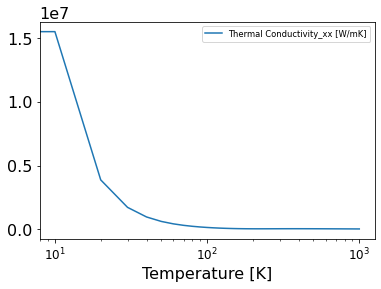

In [128]:
g_df = load_anphon_kl(g_RTAfuture.outputs.kl_file)
g_df.plot(x="Temperature [K]", y="Thermal Conductivity_xx [W/mK]")
import matplotlib.pyplot as plt
plt.xscale("log")

In [129]:
import re
import pandas as pd


In [130]:
g_RTAfuture.outputs.result_file

<SinglefileData: uuid: c7f385d4-fd7f-4928-860d-b0a6ac769372 (pk: 23799)>

In [131]:
class analzePhononOptions:
    def __init__(self, **kwargs):
        self.options= {'temp': None, 'mode': None, 'kpoint': None, 
'calc': 'kappa_boundary', 'isotope': None, 'average_gamma': True, 
'size': '1e+6', 'length': None, 'direction': None}

a = analzePhononOptions()
print(a.options)

{'temp': None, 'mode': None, 'kpoint': None, 'calc': 'kappa_boundary', 'isotope': None, 'average_gamma': True, 'size': '1e+6', 'length': None, 'direction': None}


In [132]:
g_prefix

<Str: uuid: 1e795ab7-38d5-437d-9ed4-20fd1e83503e (pk: 23789) value: Si2_k2x2x1_cubic_q5x5x5>

In [133]:
codename = "analyze_phonon@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.cwd = g_cwd
#builder.norder = g_norder
builder.prefix = g_prefix
builder.calc = Str("kappa_boundary")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"size": 1e+6})

key = "ap_kappa"
g_ap_kappa_future = nodebank.load(key)
#if g_ap_kappa_future is None:   
if True:   
    g_ap_kappa_future = submit(builder)
    print(g_ap_kappa_future)
    _wait_for_node_finished(g_ap_kappa_future, 5)
    if g_ap_kappa_future.is_finished_ok:
         nodebank.dump(key,g_ap_kappa_future)

uuid: 0dcdea8b-5161-4f62-9ded-5028ff86632d (pk: 23805) (aiida.calculations:alamode.analyze_phonon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save ap_kappa 23805


In [134]:
g_prefix

<Str: uuid: 1e795ab7-38d5-437d-9ed4-20fd1e83503e (pk: 23789) value: Si2_k2x2x1_cubic_q5x5x5>

In [135]:
codename = "analyze_phonon@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.cwd = g_cwd
builder.prefix = g_prefix
builder.calc = Str("tau")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"temp": 300.0})


key = "ap_tau"
g_ap_tau_future = nodebank.load(key)
#if g_ap_tau_future is None:   
if True:
    g_ap_tau_future = submit(builder)
    print(g_ap_tau_future)
    _wait_for_node_finished(g_ap_tau_future, 5)
    if g_ap_tau_future.is_finished_ok:
         nodebank.dump(key,g_ap_tau_future)

uuid: 45bd038b-14ed-445a-ab22-81c1b3f878ef (pk: 23814) (aiida.calculations:alamode.analyze_phonon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save ap_tau 23814


In [136]:
g_ap_tau_future.outputs.tau_file

<SinglefileData: uuid: a9be2962-a466-45c7-bb33-3e3dc836d8ab (pk: 23817)>

In [137]:
codename = "analyze_phonon@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.cwd = g_cwd
builder.prefix = g_prefix
builder.calc = Str("cumulative")
# builder.size = Float(1.0e+6)
builder.file_result = g_RTAfuture.outputs.result_file
builder.param = Dict(dict={"temp": 300.0, "length": "10000:5"})


key = "ap_cum"
g_ap_cum_future = nodebank.load(key)
if g_ap_cum_future is None:   
#if True:
    g_ap_cum_future = submit(builder)
    print(g_ap_cum_future)
    _wait_for_node_finished(g_ap_cum_future, 5)
    if g_ap_cum_future.is_finished_ok:
         nodebank.dump(key,g_ap_cum_future)

uuid: 5f6dd03f-3e8d-4808-821d-a9e1aa005719 (pk: 23823) (aiida.calculations:alamode.analyze_phonon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save ap_cum 23823


In [138]:
g_ap_tau_future

<CalcJobNode: uuid: 45bd038b-14ed-445a-ab22-81c1b3f878ef (pk: 23814) (aiida.calculations:alamode.analyze_phonon)>

In [139]:
!verdi node graph generate $g_ap_cum_future.pk

Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 23823.dot.pdf


In [140]:
g_ap_cum_future.outputs.cumulative.attributes

{'array|values': [2000, 10], 'array|columns': [10]}

In [141]:
values = g_ap_cum_future.outputs.cumulative.get_array("values")
values

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+01, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [9.98500e+03, 4.30579e+02, 2.41657e-10, ..., 1.16828e-10,
        2.89409e-10, 1.19561e+02],
       [9.99000e+03, 4.30579e+02, 2.41657e-10, ..., 1.16828e-10,
        2.89409e-10, 1.19561e+02],
       [9.99500e+03, 4.30579e+02, 2.41657e-10, ..., 1.16828e-10,
        2.89409e-10, 1.19561e+02]])

In [142]:
values = g_ap_cum_future.outputs.cumulative.get_array("values").astype(float)
splitted_header = g_ap_cum_future.outputs.cumulative.get_array("columns")
df = pd.DataFrame(values, columns=splitted_header)
df

,L [nm],kappa xx [W/mK],kappa xy [W/mK],kappa xz [W/mK],kappa yx [W/mK],kappa yy [W/mK],kappa yz [W/mK],kappa zx [W/mK],kappa zy [W/mK],kappa zz [W/mK]
0,0.0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000
1,5.0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000
2,10.0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000
3,15.0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000
4,20.0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000
...,...,...,...,...,...,...,...,...,...,...
1995,9975.0,430.579,2.416570e-10,1.168280e-10,2.416570e-10,430.579,2.894090e-10,1.168280e-10,2.894090e-10,119.561
1996,9980.0,430.579,2.416570e-10,1.168280e-10,2.416570e-10,430.579,2.894090e-10,1.168280e-10,2.894090e-10,119.561
1997,9985.0,430.579,2.416570e-10,1.168280e-10,2.416570e-10,430.579,2.894090e-10,1.168280e-10,2.894090e-10,119.561
1998,9990.0,430.579,2.416570e-10,1.168280e-10,2.416570e-10,430.579,2.894090e-10,1.168280e-10,2.894090e-10,119.561


<AxesSubplot:xlabel='L [nm]'>

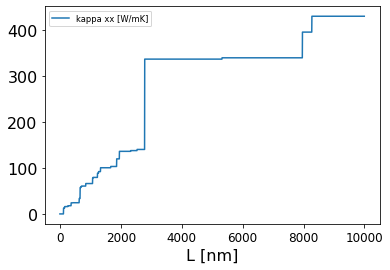

In [143]:
df.plot(x= "L [nm]", y='kappa xx [W/mK]')

## anphon spectra

In [144]:
g_prefix

<Str: uuid: 1e795ab7-38d5-437d-9ed4-20fd1e83503e (pk: 23789) value: Si2_k2x2x1_cubic_q5x5x5>

In [145]:
codename = "anphon@tutor"
code = Code.get_from_string(codename)

builder = code.get_builder()
builder.structure = g_primstructure
builder.prefix = g_prefix
builder.cwd = g_cwd
builder.norder = g_norder
builder.fcsxml = g_almopt2future.outputs.input_ANPHON_file
builder.mode = Str("RTA")
builder.kappa_spec = Int(1) # spectra
builder.qmesh = List(list=g_qmesh)
eparam = {"EMIN":0, "EMAX":550, "DELTA_E": 10.0}
builder.param= Dict(dict={"general": eparam})

key = "RTAspec"
g_RTAspecfuture = nodebank.load(key,g_force)
#if g_RTAspecfuture is None:  
if True:   
    g_RTAspecfuture = submit(builder)
    print(g_RTAspecfuture)
    _wait_for_node_finished(g_RTAspecfuture, 5)
    if g_RTAspecfuture.is_finished_ok:
         nodebank.dump(key,g_RTAspecfuture)


uuid: df100538-0c75-4031-a36b-f7ad3206c5fe (pk: 23834) (aiida.calculations:alamode.anphon)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
save RTAspec 23834


In [146]:
if True:
    ! verdi node graph generate $g_RTAspecfuture.pk

Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 23834.dot.pdf


In [147]:
g_RTAspecfuture.outputs.result.attributes

{'mode': 'RTA',
 'nmodes': 60,
 'prefix': 'Si2_k2x2x1_cubic_q5x5x5',
 'kappa_spec': 1,
 'kl_filename': 'Si2_k2x2x1_cubic_q5x5x5.kl',
 'result_filename': 'Si2_k2x2x1_cubic_q5x5x5.result',
 'kl_spec_filename': 'Si2_k2x2x1_cubic_q5x5x5.kl_spec'}

In [148]:
g_df = load_anphon_kl_spec(g_RTAspecfuture.outputs.kl_spec_file)

In [149]:
print(np.unique(g_df["Temperature [K]"].values))
g_df_select = g_df[g_df["Temperature [K]"]==300]

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000.]


<AxesSubplot:xlabel='Frequency [cm^-1]'>

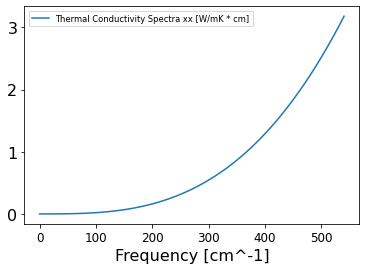

In [150]:
g_df_select.plot(x=g_df.columns[1], y=g_df.columns[2])